In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install numpy==1.23.5
!pip install jax==0.4.13 jaxlib==0.4.13
!pip install gensim
!pip install gradio


  Using cached jax-0.4.13.tar.gz (1.3 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 7.5 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.13-py3-none-any.whl size=1518817 sha256=5a8d521c03c569a7e5e8837d83d6edfd0c1f024733df35d52be270565c8ddf13
  Stored in directory: /root/.cache/pip/wheels/27/92/71/d84a9839f7b65be96d83697684a7e6d5d2db73cd9e4ce4e9a1
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.5.1
    Uninstalling jaxlib-0.5.1:
      Successfully uninstalled jaxlib-0.5.1
  Attempting uninstall: jax
    Found existing installation: jax 0.5.2
    Uninstalling jax-0.5.2:
      Successfully uninstalled jax-0.5.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
c

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import gensim.downloader as api
import tensorflow as tf
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gradio as gr

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


ERROR:jax._src.xla_bridge:Jax plugin configuration error: Plugin module %s could not be loaded
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/xla_bridge.py", line 420, in discover_pjrt_plugins
    plugin_module = importlib.import_module(plugin_module_name)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/importlib/__init__.py", line 126, in import_module
    return _bootstrap._gcd_import(name[level:], package, level)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<frozen importlib._bootstrap>", line 1204, in _gcd_import
  File "<frozen importlib._bootstrap>", line 1176, in _find_and_load
  File "<frozen importlib._bootstrap>", line 1147, in _find_and_load_unlocked
  File "<frozen importlib._bootstrap>", line 690, in _load_unlocked
  File "<frozen importlib._bootstrap_external>", line 940, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_r

True

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Text/1. Book Review Dataset/Book_review.csv")[['reviewText', 'rating']]
df.dropna(inplace=True)
df = df[df['rating'].isin([1, 2, 3, 4, 5])]
df['rating'] = df['rating'] - 1  # Make it 0–4
df.reset_index(drop=True, inplace=True)


In [ ]:
df.head()


,reviewText,rating
0,This book was the very first bookmobile book I...,4
1,"When I read the description for this book, I c...",0
2,I just had to edit this review. This book is a...,4
3,I don't normally buy 'mystery' novels because ...,4
4,"This isn't the kind of book I normally read, a...",4


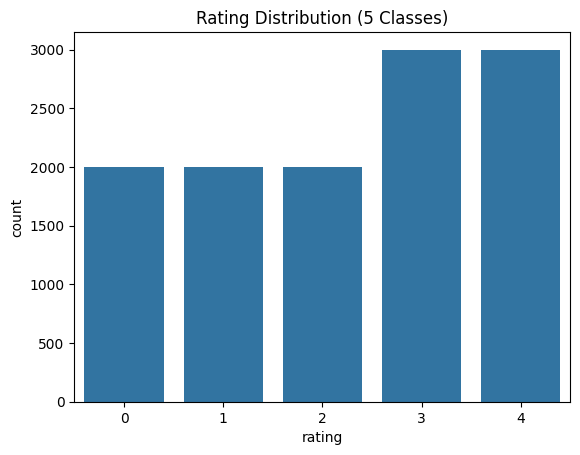

In [ ]:
sns.countplot(x='rating', data=df)
plt.title("Rating Distribution (5 Classes)")
plt.show()


In [ ]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"\s+", " ", text)
    tokens = text.split()
    return ' '.join([lemmatizer.lemmatize(w) for w in tokens if w not in stop_words])

df['cleaned'] = df['reviewText'].apply(clean_text)


In [ ]:
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned'])
sequences = tokenizer.texts_to_sequences(df['cleaned'])
word_index = tokenizer.word_index
max_len = int(np.percentile([len(x) for x in sequences], 95))
padded = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

X = padded
y = df['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))


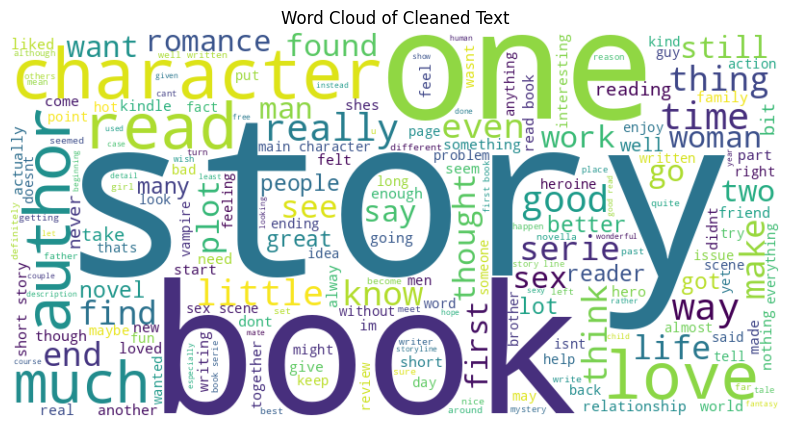

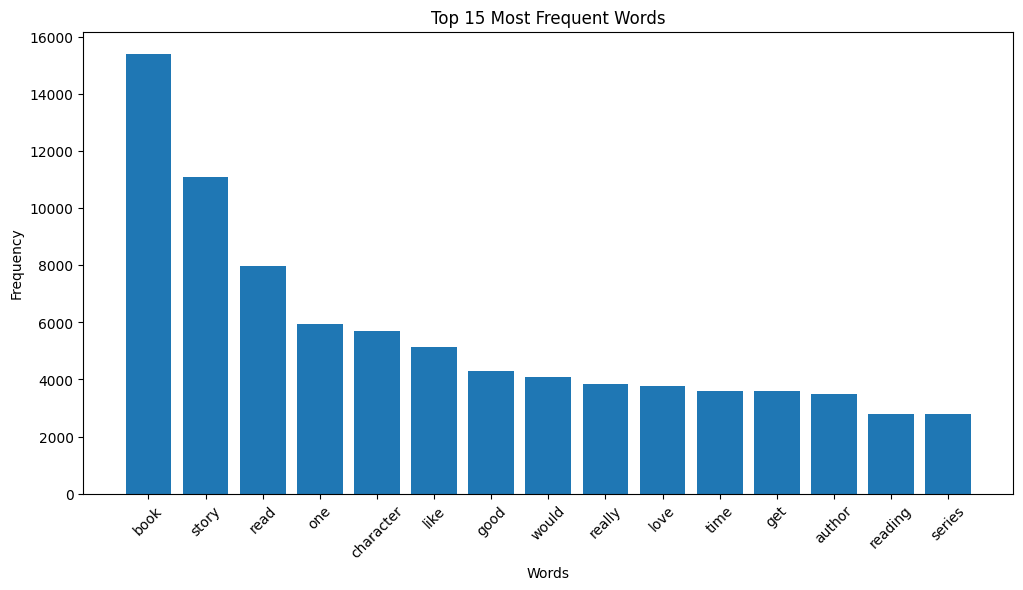

In [ ]:
from wordcloud import WordCloud
from collections import Counter

# Combine all cleaned text into one string
all_words = ' '.join(df['cleaned'].tolist())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Cleaned Text')
plt.show()

# Get most common words
words = all_words.split()
word_freq = Counter(words)
common_words = word_freq.most_common(15)

# Bar plot of most common words
words, counts = zip(*common_words)
plt.figure(figsize=(12, 6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 15 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()


In [ ]:
model_rnn = Sequential()
model_rnn.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dropout(0.5))
model_rnn.add(Dense(32, activation='relu'))
model_rnn.add(Dense(5, activation='softmax'))
model_rnn.build(input_shape=(None, max_len))
model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_rnn.summary())

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history_rnn = model_rnn.fit(X_train, y_train, validation_split=0.2, epochs=30, callbacks=[early_stop], class_weight=class_weights)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 183, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_6 (SimpleRNN)        │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,294,597 (4.94 MB)

 Trainable params: 1,294,597 (4.94 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - accuracy: 0.1992 - loss: 1.6327 - val_accuracy: 0.1781 - val_loss: 1.6112
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.2084 - loss: 1.6049 - val_accuracy: 0.2010 - val_loss: 1.6145
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.2156 - loss: 1.6030 - val_accuracy: 0.1953 - val_loss: 1.6116
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.2381 - loss: 1.5907 - val_accuracy: 0.2490 - val_loss: 1.6121


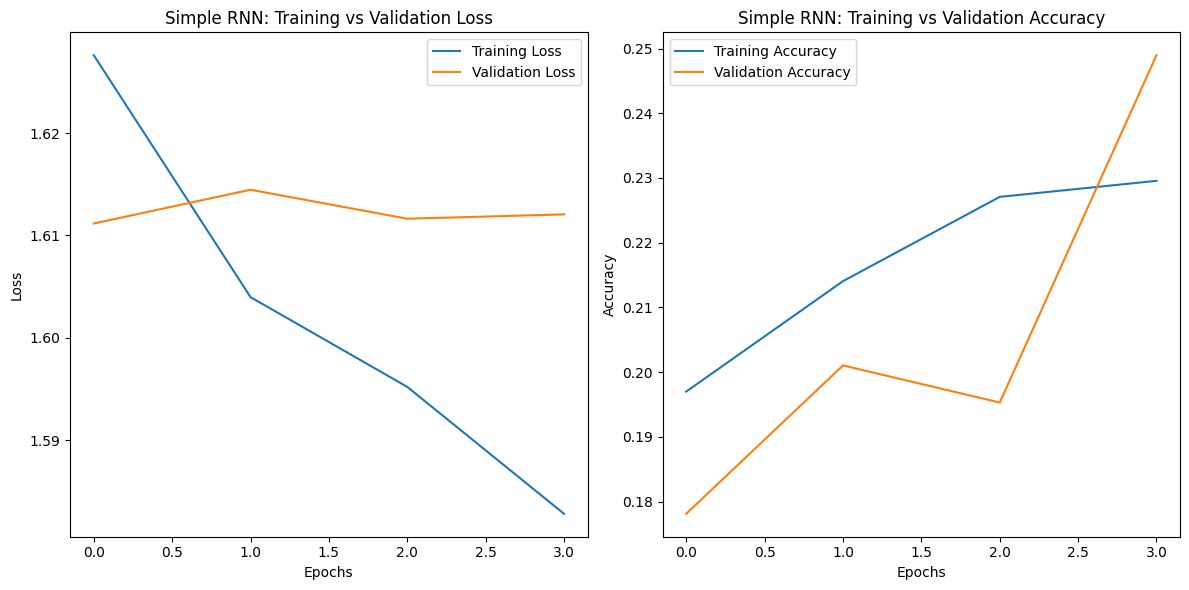

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['loss'], label='Training Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Simple RNN: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_rnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Simple RNN: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model_rnn.save('/content/drive/MyDrive/Text/simple_rnn_model.h5')


In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=10000, output_dim=128, input_length=max_len))
model_lstm.add(Bidirectional(LSTM(64)))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dropout(0.5))
model_lstm.build(input_shape=(None, max_len))
model_lstm.add(Dense(5, activation='softmax'))
model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model_lstm.summary())

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_8 (Embedding)         │ (None, 183, 128)       │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,383,109 (5.28 MB)

 Trainable params: 1,383,109 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 59s 232ms/step - accuracy: 0.2627 - loss: 1.5579 - val_accuracy: 0.3823 - val_loss: 1.3232
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 81s 230ms/step - accuracy: 0.4229 - loss: 1.2593 - val_accuracy: 0.4578 - val_loss: 1.2409
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 81s 225ms/step - accuracy: 0.5560 - loss: 1.0300 - val_accuracy: 0.4547 - val_loss: 1.2999
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 54s 224ms/step - accuracy: 0.6693 - loss: 0.8451 - val_accuracy: 0.4568 - val_loss: 1.4187
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 54s 226ms/step - accuracy: 0.7480 - loss: 0.6879 - val_accuracy: 0.4432 - val_loss: 1.5734


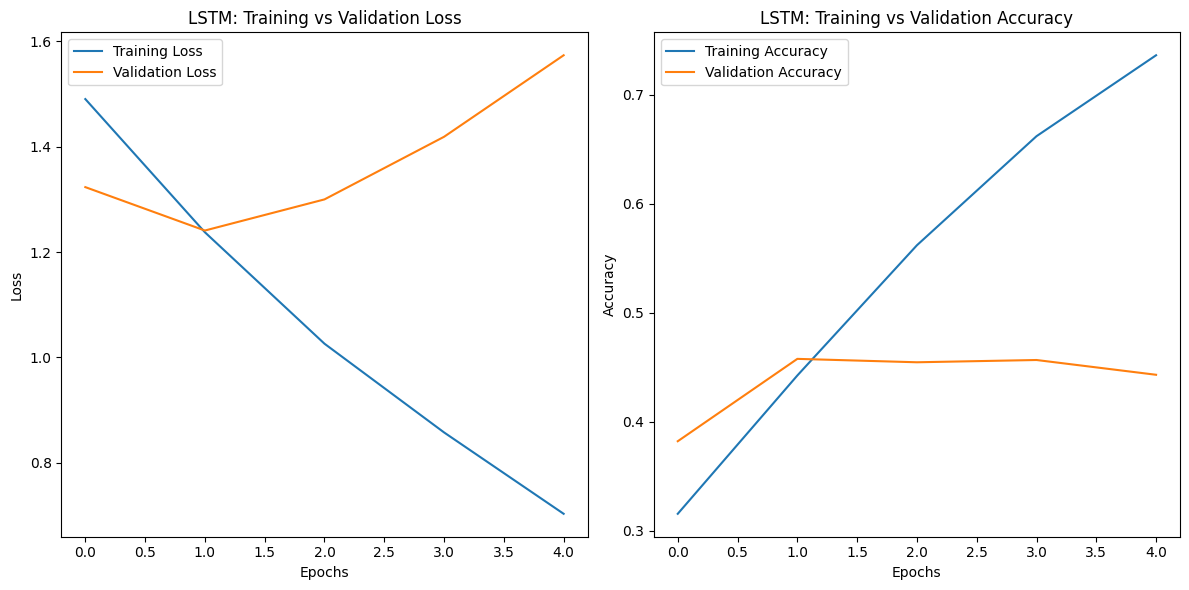

In [ ]:

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['loss'], label='Training Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('LSTM: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='Training Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model_lstm.save('/content/drive/MyDrive/Text/lstm_model.h5')

In [ ]:
embedding_model = api.load('glove-wiki-gigaword-50')
embedding_dim = 50
vocab_size = len(word_index) + 1

embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if word in embedding_model:
        embedding_matrix[i] = embedding_model[word]


[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
# Define the model
model_w2v = Sequential()
model_w2v.add(Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    weights=[embedding_matrix],
    input_length=max_len,
    trainable=False
))
model_w2v.add(LSTM(64))
model_w2v.add(Dense(32, activation='relu'))
model_w2v.add(Dropout(0.5))
model_w2v.build(input_shape=(None, max_len))
model_w2v.add(Dense(5, activation='softmax'))

# Compile the model
model_w2v.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Print model summary
print(model_w2v.summary())

# Define early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Train the model
history_w2v = model_w2v.fit(
    X_train,
    y_train,
    validation_split=0.2,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_14 (Embedding)        │ (None, 183, 50)        │     2,056,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        29,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,088,485 (7.97 MB)

 Trainable params: 31,685 (123.77 KB)

 Non-trainable params: 2,056,800 (7.85 MB)

None
Epoch 1/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 85ms/step - accuracy: 0.1995 - loss: 1.6065 - val_accuracy: 0.1729 - val_loss: 1.6077
Epoch 2/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 73ms/step - accuracy: 0.1784 - loss: 1.6018 - val_accuracy: 0.1755 - val_loss: 1.6096
Epoch 3/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - accuracy: 0.1812 - loss: 1.6024 - val_accuracy: 0.1661 - val_loss: 1.6083
Epoch 4/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 81ms/step - accuracy: 0.1807 - loss: 1.6121 - val_accuracy: 0.1714 - val_loss: 1.6069
Epoch 5/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.1917 - loss: 1.6015 - val_accuracy: 0.1682 - val_loss: 1.6070
Epoch 6/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 78ms/step - accuracy: 0.1784 - loss: 1.6050 - val_accuracy: 0.1740 - val_loss: 1.6047
Epoch 7/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 71ms/step - accuracy: 0.2004 - loss: 1.6050 - val_accuracy: 0.2526 - val_loss: 1.6064
Epoch 8/30
240/240 ━━━━━━━━━━━━━━━━━━━━ 23s 80ms/step - accuracy: 0.2393 - loss: 1.58

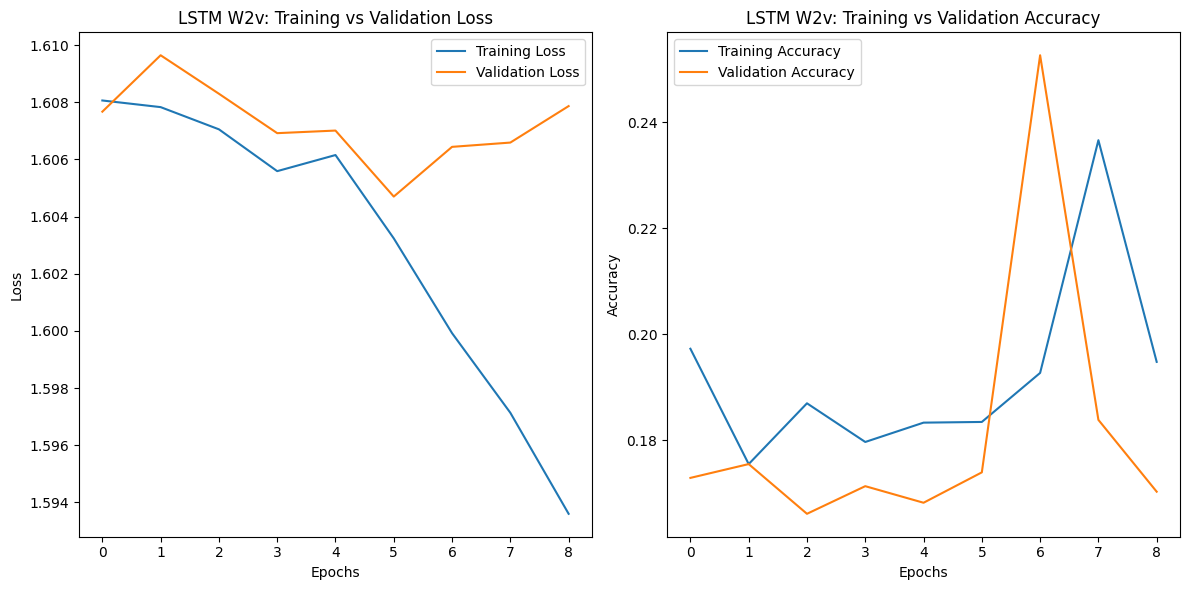

In [ ]:

plt.figure(figsize=(12, 6))

# Plotting Loss
plt.subplot(1, 2, 1)
plt.plot(history_w2v.history['loss'], label='Training Loss')
plt.plot(history_w2v.history['val_loss'], label='Validation Loss')
plt.title('LSTM W2v: Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_w2v.history['accuracy'], label='Training Accuracy')
plt.plot(history_w2v.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM W2v: Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model_w2v.save('/content/drive/MyDrive/Text/lstm_w2v_model.h5')

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

Simple RNN Accuracy: 0.175
              precision    recall  f1-score   support

           0       0.17      0.97      0.29       405
           1       0.15      0.01      0.02       394
           2       0.40      0.00      0.01       412
           3       0.24      0.02      0.04       587
           4       0.27      0.01      0.03       602

    accuracy                           0.17      2400
   macro avg       0.25      0.20      0.08      2400
weighted avg       0.25      0.17      0.07      2400



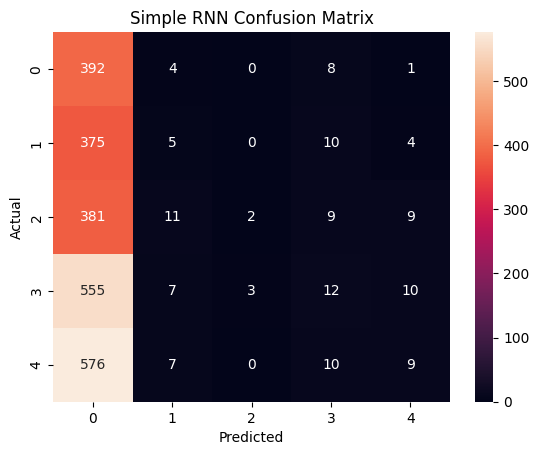

75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step

Bidirectional LSTM Accuracy: 0.4633333333333333
              precision    recall  f1-score   support

           0       0.51      0.62      0.56       405
           1       0.36      0.38      0.37       394
           2       0.34      0.33      0.34       412
           3       0.49      0.23      0.32       587
           4       0.54      0.72      0.62       602

    accuracy                           0.46      2400
   macro avg       0.45      0.46      0.44      2400
weighted avg       0.46      0.46      0.45      2400



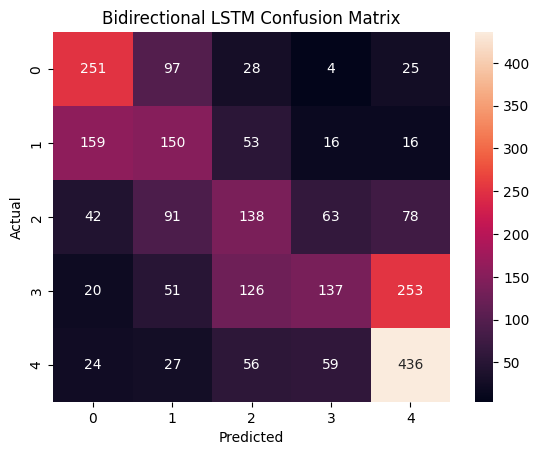

75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step

LSTM + Word2Vec Accuracy: 0.17666666666666667
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       405
           1       0.64      0.02      0.03       394
           2       0.17      0.92      0.28       412
           3       0.28      0.06      0.10       587
           4       0.14      0.00      0.00       602

    accuracy                           0.18      2400
   macro avg       0.24      0.20      0.09      2400
weighted avg       0.24      0.18      0.08      2400



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


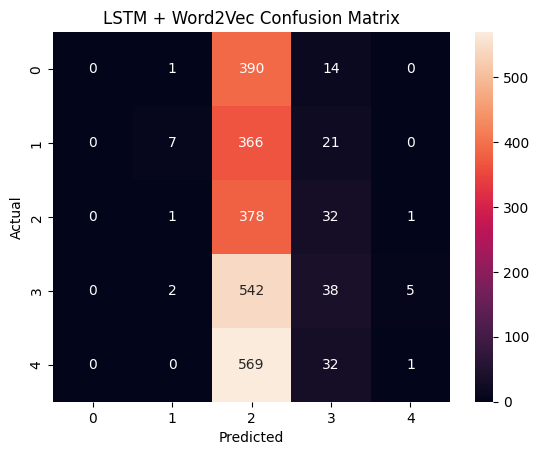

In [ ]:
def evaluate_model(name, model):
    y_pred = model.predict(X_test).argmax(axis=1)
    print(f"\n{name} Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Simple RNN", model_rnn)
evaluate_model("Bidirectional LSTM", model_lstm)
evaluate_model("LSTM + Word2Vec", model_w2v)


In [ ]:
def predict_sentiment(text):
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    padded_seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    prob = model_lstm.predict(padded_seq)[0]
    top_idx = np.argmax(prob)
    top_score = prob[top_idx] * 100
    return f"Predicted Rating: {top_idx + 1} ({top_score:.2f}%)"

gr.Interface(fn=predict_sentiment, inputs="text", outputs="text",title="Book Review Prediction").launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://a3f772982f3a0afc85.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
